In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, grad, jit, random
from flax import nnx
import optax

import matplotlib
import matplotlib.pyplot as plt

# import zarr
# import xarray as xr

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import os
os.chdir('../methods')
import lsci, supr, conf, uqno
os.chdir('../weather')

In [3]:
def risk(lower, upper, residual):
    return jnp.mean((residual > lower)*(residual < upper))

In [4]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = np.moveaxis(data[(lag + horizon):][:,None], 1, 3)
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 3)
    return x_t.copy(), y_t.copy()

def torch2jax(x):
    return jnp.array(x.numpy())

In [5]:
class ANO_layer(nnx.Module):
    def __init__(self, width, rngs: nnx.Rngs):
        self.conv = nnx.Conv(width, width, (1, 1), rngs=rngs)
        self.conv_out = nnx.Conv(width, width, (1, 1), rngs=rngs)
        
    def __call__(self, x):
        # channel mix
        h = self.conv(x)

        # spatial mix
        g = jnp.mean(x, axis = (1, 2))[:,None,None,:]

        # sum
        x = h + g
        x = nnx.relu(x)

        return self.conv_out(x)

class encode_layer(nnx.Module):
    def __init__(self, in_dim, out_dim, rngs):
        self.conv = nnx.Conv(in_dim, out_dim, (1, 1), rngs=rngs)

    def __call__(self, x):
        return self.conv(x)

class DeepANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, rngs):
        self.encode_layer = encode_layer(in_dim, width, rngs)
        self.ano1 = ANO_layer(width, rngs)
        self.ano2 = ANO_layer(width, rngs)
        self.ano3 = ANO_layer(width, rngs)
        self.decode_layer = encode_layer(width, out_dim, rngs)

    def __call__(self, x):
        f = self.encode_layer(x)
        f = self.ano1(f)
        f = self.ano2(f)
        f = self.ano3(f)
        f = self.decode_layer(f)
        return x + f

In [6]:
class ANO_layer(nnx.Module):
    def __init__(self, width, rngs: nnx.Rngs):
        self.conv = nnx.Conv(width, width, (1, 1), rngs=rngs)
        self.conv_out = nnx.Conv(width, width, (1, 1), rngs=rngs)
        
    def __call__(self, x):
        # channel mix
        h = self.conv(x)

        # spatial mix
        g = jnp.mean(x, axis = (1, 2))[:,None,None,:]

        # sum
        x = h + g
        x = nnx.relu(x)

        return self.conv_out(x)

class encode_layer(nnx.Module):
    def __init__(self, in_dim, out_dim, rngs):
        self.conv = nnx.Conv(in_dim, out_dim, (1, 1), rngs=rngs)

    def __call__(self, x):
        return self.conv(x)

class DeepANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, rngs):
        self.encode_layer = encode_layer(in_dim, width, rngs)
        self.ano1 = ANO_layer(width, rngs)
        self.ano2 = ANO_layer(width, rngs)
        self.ano3 = ANO_layer(width, rngs)
        self.decode_layer = encode_layer(width, out_dim, rngs)

    def __call__(self, x):
        f = self.encode_layer(x)
        f = self.ano1(f)
        f = self.ano2(f)
        f = self.ano3(f)
        f = self.decode_layer(f)
        return x + f

In [7]:
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)
        return jnp.mean((y_pred - y)**2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.

    return loss

def quant_step(model, optimizer, x, y):
    def loss_fn(model):
        quant = 1 - 0.1
        y_pred = model(x)
        y_abs = jnp.abs(y)
        resid = y_abs - y_pred
        loss = jnp.max(jnp.concat([quant * resid, -(1-quant) * resid], axis = 3), axis = 3)
        return jnp.mean(loss)
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # in-place updates

    return loss

train_step = nnx.jit(train_step)
quant_step = nnx.jit(quant_step)

In [8]:
dtrain = np.load('../data/era5_train_small.npy', mmap_mode='r+')
nlat, nlon = dtrain.shape[1:]
dtrain = np.mean(dtrain.reshape(-1, 4, nlat, nlon), axis = 1)

# train_mu = np.mean(dtrain, axis = (0))[None,]
# train_sd = np.std(dtrain, axis = (0))[None,]

def clim_smooth(data, kernel):
    return jax.scipy.signal.convolve2d(data, kernel, mode='same')
clim_smooth = jit(vmap(clim_smooth, (0, None)))

kernel = jnp.array([[1, 1, 1], [1, 5, 1], [1, 1, 1]])
kernel = kernel / jnp.sum(kernel)
dtrain = np.array(clim_smooth(dtrain, kernel))

In [9]:
lag, lead = 1, 1
xtrain, ytrain = split_data(dtrain, lag, lead)
train_data = TensorDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)

In [10]:
epochs = 10
trace = []

model = DeepANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [11]:
trace = []

quant = DeepANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(quant, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = quant_step(quant, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [12]:
# del dtrain, xtrain, ytrain
dval = np.load('../data/era5_val_small.npy', mmap_mode='r+')
dtest = np.load('../data/era5_test_small.npy', mmap_mode='r+')

dval = np.mean(dval.reshape(-1, 4, nlat, nlon), axis = 1)
dtest = np.mean(dtest.reshape(-1, 4, nlat, nlon), axis = 1)

# dval = (dval - train_mu) / train_sd
# dtest = (dtest - train_mu) / train_sd

dval = np.array(clim_smooth(dval, kernel))
dtest = np.array(clim_smooth(dtest, kernel))

xval, yval = split_data(dval, lag, lead)
xtest, ytest = split_data(dtest, lag, lead)

val_data = TensorDataset(torch.Tensor(xval), torch.Tensor(yval))
test_data = TensorDataset(torch.Tensor(xtest), torch.Tensor(ytest))
val_loader = DataLoader(val_data, batch_size = 100)
test_loader = DataLoader(test_data, batch_size = 100)

In [13]:
yval_hat = []
for xt, _ in tqdm(val_loader, leave = False):
    xt = torch2jax(xt)
    yval_hat.append(model(xt))

ytest_hat = []
for xt, _ in tqdm(test_loader, leave = False):
    xt = torch2jax(xt)
    ytest_hat.append(model(xt))

yval_quant = []
for xt, _ in tqdm(val_loader, leave = False):
    xt = torch2jax(xt)
    yval_quant.append(quant(xt))

ytest_quant = []
for xt, _ in tqdm(test_loader, leave = False):
    xt = torch2jax(xt)
    ytest_quant.append(quant(xt))

yval_hat = jnp.concat(yval_hat, axis = 0)
ytest_hat = jnp.concat(ytest_hat, axis = 0)
yval_quant = jnp.concat(yval_quant, axis = 0)
ytest_quant = jnp.concat(ytest_quant, axis = 0)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [14]:
# nproj = 100
# gamma1 = 0.2
# alpha = 0.1
# nval = xval.shape[0]
# alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)

# yval = yval.reshape(yval.shape[0], -1)
# yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
# pca_state = lsci.phi_state(yval, yval_hat, nproj)

In [15]:
# UQNO lambda estimate
yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
yval_quant = yval.reshape(yval_quant.shape[0], -1)
ytest_quant = ytest_quant.reshape(ytest_quant.shape[0], -1)

alpha = 0.1
delta = 0.01
m = 30*60
tau = 2 * jnp.sqrt(-jnp.log(delta)/(2*m))
sg = jnp.abs(yval - yval_hat) / yval_quant
sg = jnp.quantile(sg, 1-alpha+tau, axis = (1))
nval = sg.shape[0]

adj_alpha = 1 - jnp.ceil((nval + 1) * (delta - jnp.exp(-2*m*tau**2)))/nval
lam_uqno = jnp.quantile(sg, adj_alpha)
lam_uqno

Array(1.3467916, dtype=float32)

In [16]:
def embed_var(x):
    p = x.shape[1] * x.shape[2] * x.shape[3]
    xstd = jnp.std(x, axis = (1, 2, 3))[:,None]
    return jnp.repeat(xstd, p, axis = 1)

In [17]:
nproj = nlat*nlon
gamma1 = 0.1
gamma2 = 0.5
alpha = 0.1
nsamp = 5000
nval = xval.shape[0]
alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)
alpha2 = 1 - jnp.ceil((1-alpha) * (gamma2*nval + 1))/(gamma2*nval)

lsc1_rc = []
lsc2_rc = []
lsc3_rc = []
conf_rc = []
supr_rc = []
uqn1_rc = []
oracle_rc = []

lsc1_width = []
lsc2_width = []
lsc3_width = []
conf_width = []
supr_width = []
uqn1_width = []
oracle_width = []

yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
pca_state = lsci.phi_state(yval, yval_hat, nproj)

rval = (yval - yval_hat).squeeze().reshape(-1, nlat*nlon)
rtest = (ytest - ytest_hat).squeeze().reshape(-1, nlat*nlon)

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)

for i in trange(0, ytest.shape[0], 10):
    # Oracle
    oracle_lower = -(jnp.abs(rtest[i]) + 1e-4)
    oracle_upper = jnp.abs(rtest[i]) + 1e-4
    oracle_rc.append(risk(oracle_lower, oracle_upper, rtest[i]))
    oracle_width.append(jnp.median(oracle_upper - oracle_lower))
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci(rval, 
                                       xval.reshape(-1, lag*nlat*nlon), 
                                       xtest[i].reshape(-1, lag*nlat*nlon),
                                       pca_state, alpha1, gamma1, nsamp)
    lsc1_rc.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # # LSCI
    # lsc2_lower, lsc2_upper = lsci.lsci(rval, 
    #                                    embed_var(xval), 
    #                                    embed_var(xtest[i:(i+1)]), 
    #                                    pca_state, alpha1, gamma1, nsamp)
    # lsc2_rc.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    # lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))

    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci(rval, 
                                       rval, 
                                       rtest[i],
                                       pca_state, alpha2, gamma2, nsamp)
    lsc2_rc.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))
    
    # CONF 
    conf_rc.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.median(conf_upper - conf_lower))
    
    # SUPR
    supr_rc.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.median(supr_upper - supr_lower))
    
    # UQNO
    uqn1_rc.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.median(uqn1_upper[i] - uqn1_lower[i]))

    
conf_rc = np.array(conf_rc)
supr_rc = np.array(supr_rc)
uqn1_rc = np.array(uqn1_rc)
lsc1_rc = np.array(lsc1_rc)
lsc2_rc = np.array(lsc2_rc)
lsc3_rc = np.array(lsc3_rc)
oracle_rc = np.array(oracle_rc)

conf_width = np.array(conf_width)
supr_width = np.array(supr_width)
uqn1_width = np.array(uqn1_width)
lsc1_width = np.array(lsc1_width)
lsc2_width = np.array(lsc2_width)
lsc3_width = np.array(lsc3_width)
oracle_width = np.array(oracle_width)

  0%|          | 0/183 [00:00<?, ?it/s]

In [18]:
# noise_sd = np.std(rtest[:(365*5)], axis = 1)
noise_sd = np.std(rtest[::10], axis = 1)

gamma = 0.99

risk_control = np.mean(oracle_rc >= gamma), \
               np.mean(conf_rc >= gamma), \
               np.mean(supr_rc >= gamma), \
               np.mean(uqn1_rc >= gamma), \
               np.mean(lsc1_rc >= gamma), \
               np.mean(lsc2_rc >= gamma)

width = np.mean(oracle_width), \
        np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = 0, \
           np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = np.corrcoef([noise_sd, oracle_width])[0,1], \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [19]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

1.000 & 0.000 & 1.119 & 0.485 \\
0.995 & -0.524 & 11.348 & 0.000 \\
1.000 & -0.497 & 12.498 & 0.000 \\
1.000 & -0.542 & 49.784 & 0.175 \\
0.902 & -0.672 & 9.981 & -0.077 \\
0.852 & -0.661 & 9.953 & -0.090 \\


In [20]:
lw0 = lsci.local_weights(xval.reshape(-1, nlat*nlon), xtest[0:1].reshape(-1, nlat*nlon), 0.99).squeeze()
lw0 = lsci.local_weights(rval, rtest[0:1], 0.99).squeeze()
lw1 = lsci.local_weights(rval, rtest[1:2], 0.99).squeeze()
lw.shape

NameError: name 'lw' is not defined

In [ ]:
plt.scatter(lw0, lw1)

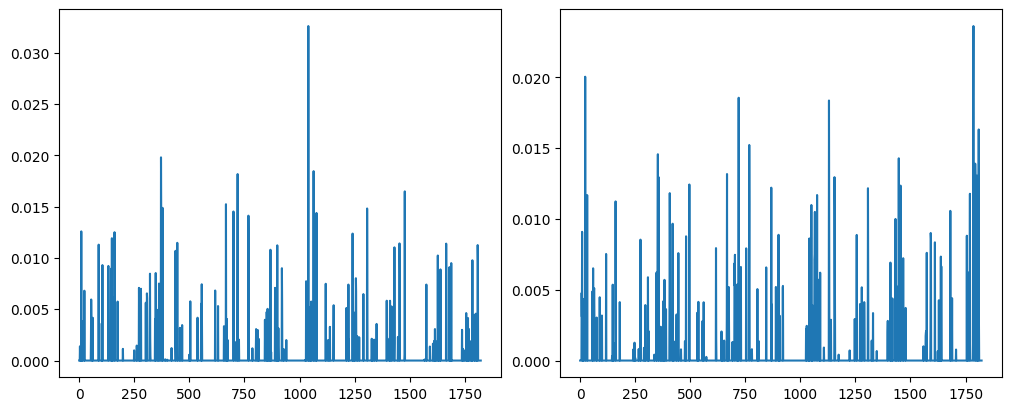

In [296]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 4))

ax[0].plot(lw0)
ax[1].plot(lw1)

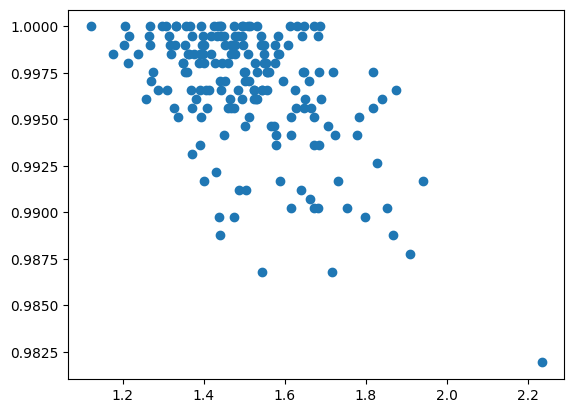

In [279]:
plt.scatter(noise_sd, lsc2_rc)
# plt.scatter(noise_sd, uqn1_width)

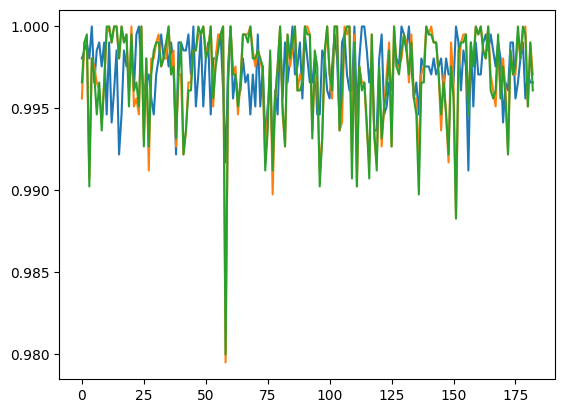

In [34]:
plt.plot(uqn1_rc)
plt.plot(lsc1_rc)
plt.plot(lsc2_rc)

In [46]:
x0 = xval.reshape(-1, lag*nlat*nlon)
x1 = xtest.reshape(-1, lag*nlat*nlon)

r0 = rval.reshape(-1, lag*nlat*nlon)
r1 = rtest.reshape(-1, lag*nlat*nlon)

x0.shape, x1.shape

((1824, 2048), (1824, 2048))

In [119]:
xmat = (x0 @ x1[::50].T)
rmat = (r0 @ r1[::50].T)

In [120]:
# plt.plot(xmat)
# plt.show()

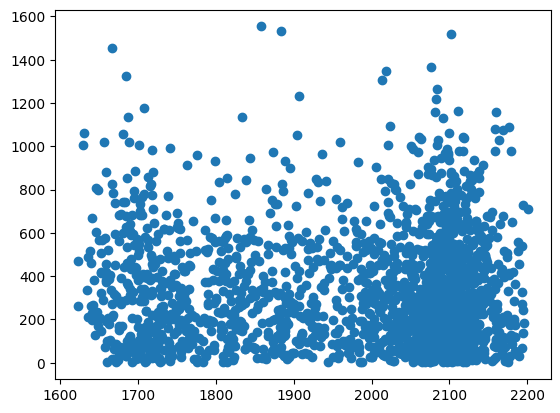

In [121]:
plt.scatter(xmat[:,10]/300, jnp.abs(rmat[:,10]))

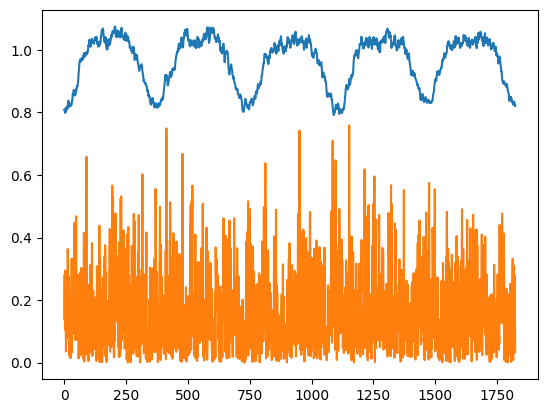

In [112]:
plt.plot(xmat[:,10]/300)
plt.plot(jnp.abs(rmat[:,10]))

Array([[1.        , 0.07496862],
       [0.07496862, 1.        ]], dtype=float32)

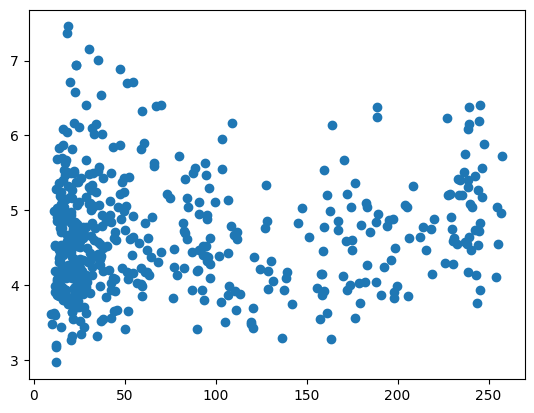

In [164]:
model(xtest[0:10])

xmat = jnp.mean((model(xval[0:500]) - model(xtest[0:1])).reshape(500,-1)**2, axis = 1)
rmat = jnp.mean((r0[0:500] - r1[0])**2, axis = 1)

plt.scatter(xmat, rmat)
jnp.corrcoef(jnp.stack([xmat, rmat], axis = 0))

In [159]:
xmat.shape

(100,)

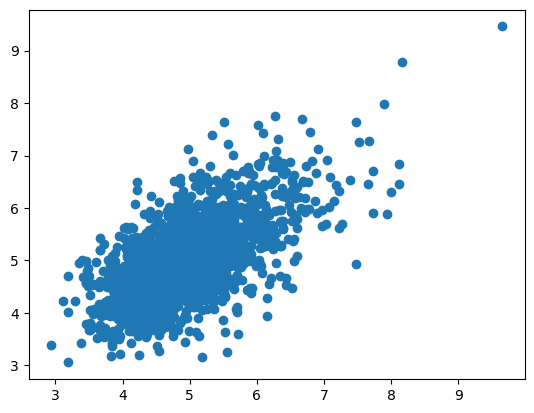

In [280]:
xmat = jnp.mean((r0 - r1[1])**2, axis = 1)
rmat = jnp.mean((r0 - r1[2])**2, axis = 1)

plt.scatter(xmat, rmat)

In [227]:
jnp.corrcoef(jnp.stack([xmat, rmat], axis = 0))

Array([[1.        , 0.64725983],
       [0.64725983, 1.        ]], dtype=float32)

In [51]:
i = 10
lsc1_lower, lsc1_upper = lsci.lsci(rval, 
                                   xval.reshape(-1, lag*nlat*nlon), 
                                   xtest[i].reshape(-1, lag*nlat*nlon), 
                                   pca_state, alpha1, gamma1, nsamp)

lsc1_lower, lsc1_upper = lsc1_lower.reshape(nlat, nlon), lsc1_upper.reshape(nlat, nlon)

In [70]:
loweri, upperi = lsc1_lower.reshape(nlat, nlon), lsc1_upper.reshape(nlat, nlon)
yi = ytest_hat[i].reshape(nlat, nlon)

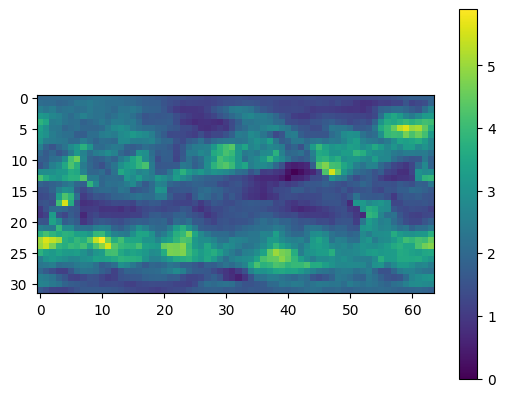

In [71]:
plt.imshow(yi + upperi - loweri)
plt.colorbar()

In [107]:

oracle_rc = []
oracle_width = []

In [108]:
for i in trange(0, 200):
    # Oracle    
    oracle_lower = -jnp.abs(rtest[i])- 1e-7
    oracle_upper = jnp.abs(rtest[i])+ 1e-7
    oracle_rc.append(risk(oracle_lower, oracle_upper, rtest[i]))
    oracle_width.append(jnp.mean(oracle_upper - oracle_lower))

  0%|          | 0/200 [00:00<?, ?it/s]

In [109]:

oracle_rc = np.array(oracle_rc)
oracle_width = np.array(oracle_width)

In [110]:
noise_sd = np.std(rtest[:200], axis = 1)

risk_control = np.mean(oracle_rc >= 0.99), \
               np.mean(conf_rc >= 0.99), \
               np.mean(supr_rc >= 0.99), \
               np.mean(uqn1_rc >= 0.99), \
               np.mean(lsc1_rc >= 0.99), \
               np.mean(lsc2_rc >= 0.99)

width = np.mean(oracle_width), \
        np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = 0, \
           np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = np.corrcoef([noise_sd, oracle_width])[0,1], \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [111]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

1.000 & 0.000 & 0.436 & 0.913 \\
1.000 & -0.265 & 2.673 & 0.000 \\
1.000 & -0.265 & 3.002 & 0.000 \\
1.000 & -0.285 & 5.642 & -0.141 \\
0.925 & -0.655 & 1.785 & 0.226 \\
0.935 & -0.662 & 1.791 & 0.217 \\
